In [1]:
import sys
import random
import os
import subprocess

import numpy as np
import torch
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import OneCycleLR

from nuy_v2_loader import NYUV2Dataset, DEFAULT_TEST_TRANSFORMS
from stepper import Stepper
from summary_writer import SummaryWriter, WandBSummaryWritter
from loss import  nyuv2_multiterm_loss_fn, ZScoreEWMALoss, nyuv2_loss_fn
from models.compose_net import ComposeNet

In [2]:
%run -i 'constants.py'

In [3]:
BATCH_SIZE = 8
MAX_DATA_LENGHT = None

EPOCHS = 10
LR = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False    
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
# if not os.path.exists('ds/diode.tar.gz'):
#     subprocess.run(
#         ['curl', '-L', '-o', 'ds/diode.tar.gz', 'http://diode-dataset.s3.amazonaws.com/train.tar.gz'],
#         check=True
#     )

In [6]:
transforms = Compose([
  ToTensor(),
])

rgb_t = Compose([
  ToTensor(),
  Normalize(mean=RGB.mean, std=RGB.std),
])

rgb_t_train = Compose([
  ToTensor(),
  Normalize(mean=RGB.mean, std=RGB.std),
  v2.RandomChannelPermutation()
])

train_dataset = NYUV2Dataset("ds", rgb_t_train, transforms, 'train', download=False, max_lenght=MAX_DATA_LENGHT)
test_dataset = NYUV2Dataset("ds", rgb_t, transforms, 'test', download=False, max_lenght=MAX_DATA_LENGHT, common_transforms=DEFAULT_TEST_TRANSFORMS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


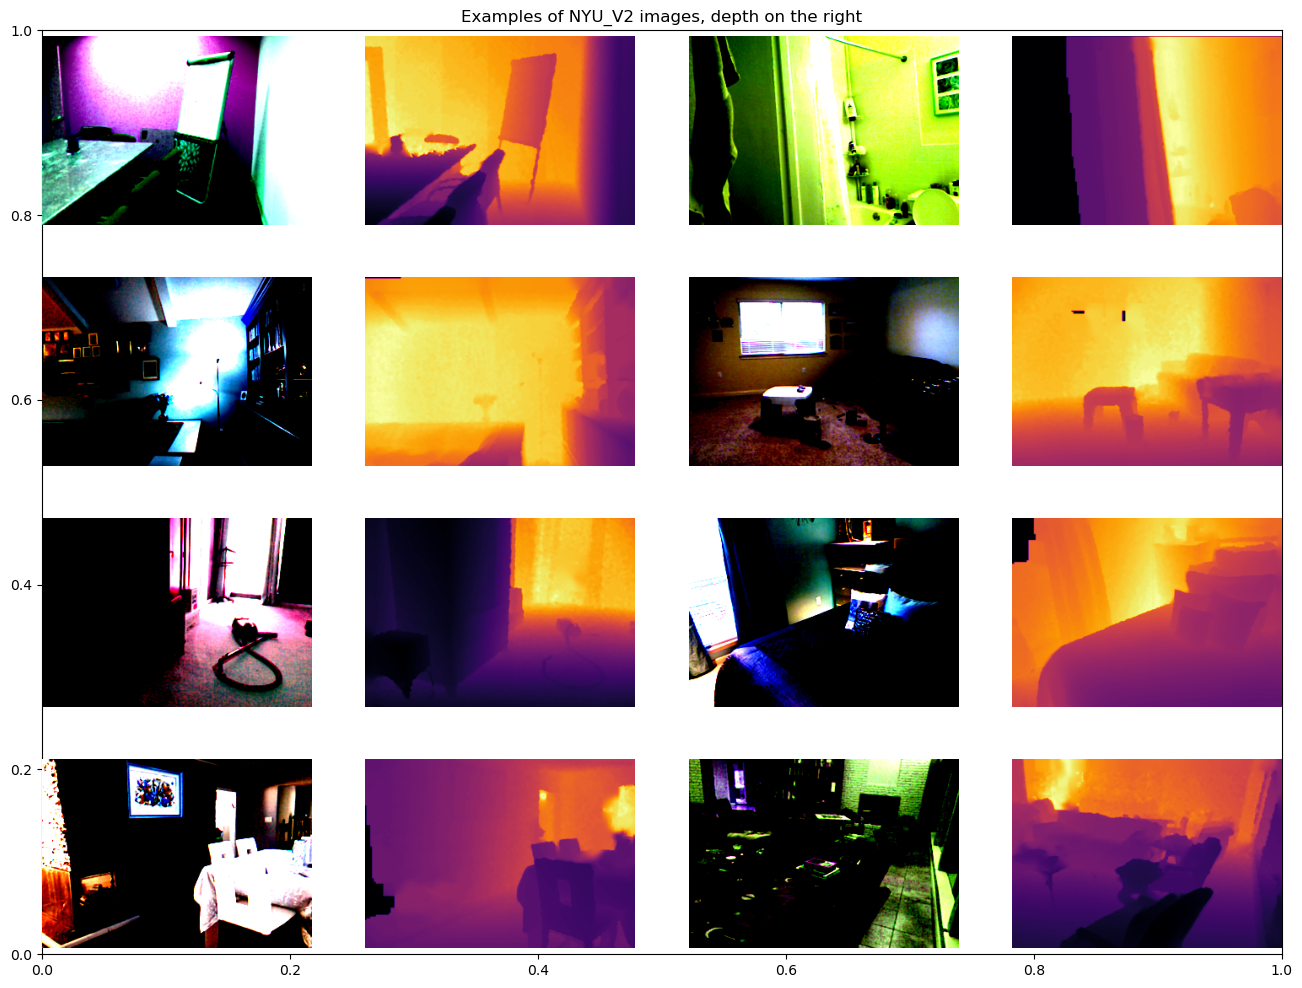

In [7]:
random_pick = np.random.randint(0, 45000, 8)

plt.figure(figsize=(16, 12))
plt.title("Examples of NYU_V2 images, depth on the right")
for i, img in enumerate(random_pick):
  ax = plt.subplot(4, 4, i * 2 +1)
  rgb, depth = train_dataset[img]
  ax.imshow(rgb.permute((1, 2, 0)))
  ax.set_axis_off()
  
  ax = plt.subplot(4, 4, i * 2 + 2)
  ax.imshow(depth[0], cmap='inferno')
  ax.set_axis_off()

# As we can see data isn't perfect, sensor weren't able to capture highly illuminated objects, mirrors and etc

## Baseline

In [8]:
summary_writer = WandBSummaryWritter(addon_stream=sys.stdout)

generator = torch.Generator()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = ComposeNet(inputsize=INPUT_SIZE, decoder_channels=256, vit_channels_in=64, classes=128)
optim = AdamW(model.parameters(), lr=LR)
lr_scheduler = OneCycleLR(
  optim, 
  LR, 
  epochs=EPOCHS, 
  steps_per_epoch=len(train_loader),
  cycle_momentum=True,
  div_factor=25,
  final_div_factor=1e2
)

loss_fn = ZScoreEWMALoss(loss_fn=nyuv2_multiterm_loss_fn, n_functions=3, device=device).train()
stepper = Stepper(model, optim=optim, loss_fn=loss_fn, summary_writter=summary_writer)
stepper.set_loaders(train_loader, val_loader)
stepper.set_lr_schedulers(lr_scheduler, over_batch=True)
stepper.to(device)

summary_writer.register(
  project='pure_depth',
  config={
    'architecture': repr(model),
    'optim': 'AdamW',
    'device': device,
    'batch_size': BATCH_SIZE,
    'loss_fn': stepper.loss_fn.__doc__,
    'scale_invariance_alpha': SCALE_INVARIANCE_ALPHA,
    'epochs': EPOCHS
  }
)

Using cache found in /home/jovyan/.cache/torch/hub/facebookresearch_WSL-Images_main
/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: percalee. Use `wandb login --relogin` to force relogin


In [9]:
# summary_writer = WandBSummaryWritter(addon_stream=sys.stdout)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
# resnet101_refinet = Resnet101RefineNet()
# optim = MultiTermAdam(resnet101_refinet.parameters(), lr=1e-4, betas=(0.8, 0.98, 0.7))
# stepper = MultiTermLossStepper(resnet101_refinet, optim=optim, loss_fn=nyuv2_multiterm_loss_fn, summary_writter=summary_writer)
# stepper.set_loaders(train_loader, val_loader)
# stepper.to(device)

# summary_writer.register(
#   project='pure_depth',
#   config={
#     'architecture': 'Resnet101_Refinet',
#     'optim': 'MultiTermAdam',
#     'device': device,
#     'batch_size': BATCH_SIZE,
#     'loss_fn': stepper.loss_fn.__doc__
#   }
# )

In [ ]:
# torch.autograd.set_detect_anomaly(True)
stepper.train(n_epochs=EPOCHS)
stepper.save_checkpoint(file_name=f'artifacts/{summary_writer.name}')

train step:   6%|▌         | 355/5948 [06:48<1:44:59,  1.13s/batch, loss=nan]

In [ ]:
# stepper.load_checkpoint('artifacts/misunderstood-lion-245')

In [ ]:
# Just sanity check
x, y = test_dataset[10]
stepper.model.eval()
pred = stepper.model(x.unsqueeze(0).to(device))

vmax = y.max()
plt.figure(figsize=(8, 6))
ax0 = plt.subplot(1, 2, 1)
show = ax0.imshow(
  np.transpose(pred[0].detach().cpu().numpy(), (1, 2, 0)),
  cmap='inferno',
  vmin=0
)
plt.colorbar(show, ax=ax0)
ax1 = plt.subplot(1, 2, 2)
show = ax1.imshow(
  np.transpose(y.detach().numpy(), (1, 2, 0)), 
  cmap='inferno', 
  vmin=0
)
plt.colorbar(show, ax=ax1)

In [ ]:
summary_writer.track_object({"train_eval": stepper.gather_metrics(False)})

In [ ]:
summary_writer.finalize()